# Mixture Density Network

Reproducing the classic Bishop MDN network tasks in Keras. The idea in this task is to predict a the value of an inverse sine function. This function has multiple real-valued solutions at each point, so the ANN model needs to have the capacity to handle this in it's loss function. An MDN is a good way to handle the predictions of these multiple output values.

There's a couple of other versions of this task, and this implementation owes much to the following:

- [David Ha - Mixture Density Networks with TensorFlow](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/)
- [Mixture Density Networks in Edward](http://edwardlib.org/tutorials/mixture-density-network)

In [1]:
import keras
from keras import backend as K
from keras.layers import Dense, Input, merge
from keras.engine.topology import Layer
import numpy as np
from tensorflow.contrib.distributions import Categorical, Mixture, MultivariateNormalDiag
import tensorflow as tf

def elu_plus_one_plus_epsilon(x):
    """ELU activation with a very small addition to help prevent NaN in loss."""
    return (K.elu(x) + 1 + 1e-8)
    

class MDN(Layer):
    """A Mixture Density Network Layer for Keras.
    This layer has a few tricks to avoid NaNs in the loss function when training:
        - Activation for variances is ELU + 1 + 1e-8 (to avoid very small values)
        - Mixture weights (pi) are trained in as logits, not in the softmax space.
        
    A loss function needs to be constructed with the same output dimension and number of mixtures.
    A sampling function is also provided to sample from distribution parametrised by the MDN outputs.
    """
    
    def __init__(self, output_dim, num_mix, **kwargs):
        self.output_dim = output_dim
        self.num_mix = num_mix
        with tf.name_scope('MDN'):
            self.mdn_mus     = Dense(self.num_mix * self.output_dim, name='mdn_mus') # mix*output vals, no activation
            self.mdn_sigmas  = Dense(self.num_mix * self.output_dim, activation=elu_plus_one_plus_epsilon, name='mdn_sigmas') # mix*output vals exp activation
            self.mdn_pi      = Dense(self.num_mix, name='mdn_pi') # mix vals, logits
        super(MDN, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mdn_mus.build(input_shape)
        self.mdn_sigmas.build(input_shape)
        self.mdn_pi.build(input_shape)
        self.trainable_weights = self.mdn_mus.trainable_weights + self.mdn_sigmas.trainable_weights + self.mdn_pi.trainable_weights
        self.non_trainable_weights = self.mdn_mus.non_trainable_weights + self.mdn_sigmas.non_trainable_weights + self.mdn_pi.non_trainable_weights
        super(MDN, self).build(input_shape)
        
    def call(self, x, mask=None):
        with tf.name_scope('MDN'):
            mdn_out = keras.layers.concatenate([self.mdn_mus(x), 
                                                self.mdn_sigmas(x), 
                                                self.mdn_pi(x)], 
                                               name='mdn_outputs')
        return mdn_out
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)



def get_mixture_loss_func(output_dim, num_mixes):
    """Construct a loss functions for the MDN layer parametrised by number of mixtures."""
    
    # Construct a loss function with the right number of mixtures and outputs
    def loss_func(y_true, y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim, 
                                                                         num_mixes * output_dim, 
                                                                         num_mixes], 
                                             axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
            in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        loss = mixture.log_prob(y_true)
        loss = tf.negative(loss)
        loss = tf.reduce_mean(loss)
        return loss
    
    # Actually return the loss_func
    with tf.name_scope('MDN'):
        return loss_func
    
def get_mixture_sampling_fun(output_dim, num_mixes):
    """Construct a sampling function for the MDN layer parametrised by mixtures and output dimension."""
        
    # Construct a loss function with the right number of mixtures and outputs
    def sampling_func(y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim, 
                                                                         num_mixes * output_dim, 
                                                                         num_mixes], 
                                             axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
            in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        samp = mixture.sample()
        # Todo: temperature adjustment for sampling function.
        return samp
    
    # Actually return the loss_func
    with tf.name_scope('MDNLayer'):
        return sampling_func
    
def get_mixture_mse_accuracy(output_dim, num_mixes):
    """Construct an MSE accuracy function for the MDN layer 
    that takes one sample and compares to the true value."""
    
    # Construct a loss function with the right number of mixtures and outputs
    def mse_func(y_true, y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim, 
                                                                         num_mixes * output_dim, 
                                                                         num_mixes], 
                                             axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
            in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        samp = mixture.sample()
        mse = tf.reduce_mean(tf.square(samp - y_true), axis=-1)
        # Todo: temperature adjustment for sampling functon.
        return mse
    
    # Actually return the loss_func
    with tf.name_scope('MDNLayer'):
        return mse_func

Using TensorFlow backend.


## Generate Synthetic Data

Data generation

<IPython.core.display.Javascript object>


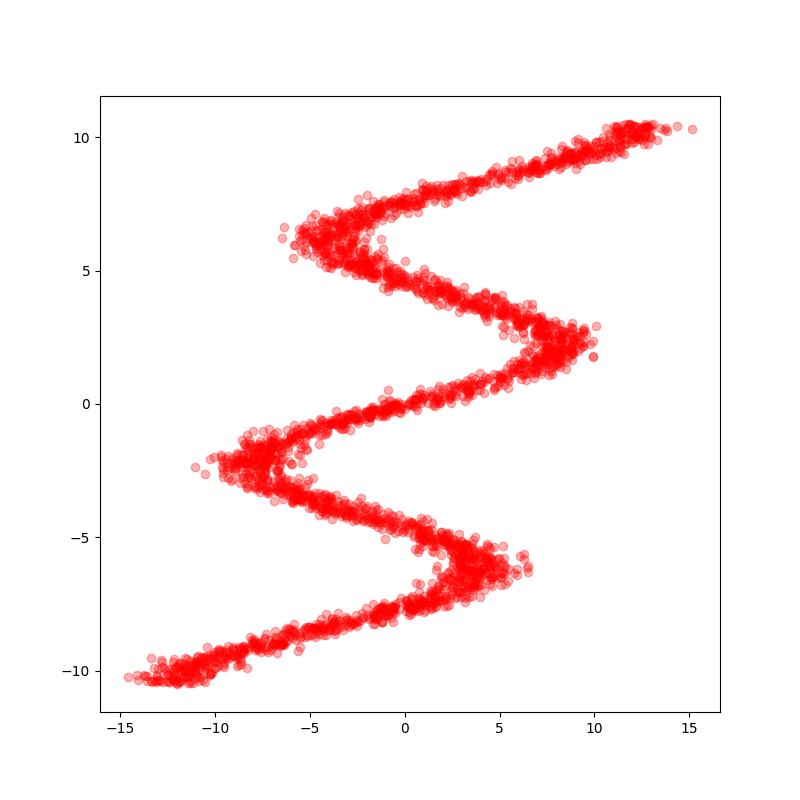

In [11]:
import matplotlib.pyplot as plt
%matplotlib notebook


## Generating some data:

NSAMPLE = 3000

y_data = np.float32(np.random.uniform(-10.5, 10.5, NSAMPLE))
r_data = np.random.normal(size=NSAMPLE)
x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
x_data = x_data.reshape((NSAMPLE, 1))

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', alpha=0.3)
plt.show()

## Build the MDN Model

Now we will construct the MDN model in Keras. This uses the `Sequential` model interface in Keras.

The `MDN` layer comes after one or more `Dense` layers. You need to define the output dimension and number of mixtures for the MDN like so: `MDN(output_dimension, number_mixtures)`.

For this problem, we only need an output dimension of 1 as we are predicting one value (y). Adding more mixtures adds a more parameters (model is more complex, takes longer to train), but might help make the solutions better. You can see from the training data that there are at maximum 5 different layers to predict in the curve, so setting `N_MIXES = 5` is a good place to start.

For MDNs, we have to use a special loss function that can handle the mixture parameters: the function has to take into account the number of output dimensions and mixtures.

In [3]:
N_HIDDEN = 15
N_MIXES = 10

model = keras.Sequential()
model.add(keras.layers.Dense(N_HIDDEN, batch_input_shape=(None, 1), activation='relu'))
model.add(keras.layers.Dense(N_HIDDEN, activation='relu'))
model.add(MDN(1, N_MIXES))
model.compile(loss=get_mixture_loss_func(1,N_MIXES), optimizer=keras.optimizers.Adam()) #, metrics=[get_mixture_mse_accuracy(1,3)])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15)                30        
_________________________________________________________________
dense_2 (Dense)              (None, 15)                240       
_________________________________________________________________
mdn_1 (MDN)                  (None, 1)                 480       
Total params: 750
Trainable params: 750
Non-trainable params: 0
_________________________________________________________________


### Training the model

Now we train the model using Keras' normal `fit` command.

In [4]:
history = model.fit(x=x_data, y=y_data, batch_size=128, epochs=500, validation_split=0.15)

Train on 2550 samples, validate on 450 samples
Epoch 1/500
2550/2550 [==============================] - 2s 596us/step - loss: 5.7564 - val_loss: 4.9779
Epoch 2/500
2550/2550 [==============================] - 0s 31us/step - loss: 4.6969 - val_loss: 4.3177
Epoch 3/500
2550/2550 [==============================] - 0s 31us/step - loss: 4.1904 - val_loss: 4.0030
Epoch 4/500
2550/2550 [==============================] - 0s 30us/step - loss: 3.9327 - val_loss: 3.8309
Epoch 5/500
2550/2550 [==============================] - 0s 32us/step - loss: 3.7761 - val_loss: 3.7241
Epoch 6/500
2550/2550 [==============================] - 0s 38us/step - loss: 3.6691 - val_loss: 3.6337
Epoch 7/500
2550/2550 [==============================] - 0s 35us/step - loss: 3.5880 - val_loss: 3.5642
Epoch 8/500
2550/2550 [==============================] - 0s 31us/step - loss: 3.5281 - val_loss: 3.5240
Epoch 9/500
2550/2550 [==============================] - 0s 30us/step - loss: 3.4726 - val_loss: 3.4813
Epoch 10/500
255

2550/2550 [==============================] - 0s 32us/step - loss: 1.9326 - val_loss: 1.9734
Epoch 79/500
2550/2550 [==============================] - 0s 32us/step - loss: 1.9322 - val_loss: 1.9762
Epoch 80/500
2550/2550 [==============================] - 0s 32us/step - loss: 1.9037 - val_loss: 1.9768
Epoch 81/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.9104 - val_loss: 1.9700
Epoch 82/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.8979 - val_loss: 1.9521
Epoch 83/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.8829 - val_loss: 1.9676
Epoch 84/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.8742 - val_loss: 1.9294
Epoch 85/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.8667 - val_loss: 1.9228
Epoch 86/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.8590 - val_loss: 1.9084
Epoch 87/500
2550/2550 [==============================] - 0s 31us/st

2550/2550 [==============================] - 0s 35us/step - loss: 1.7273 - val_loss: 1.7918
Epoch 156/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.7195 - val_loss: 1.7744
Epoch 157/500
2550/2550 [==============================] - 0s 32us/step - loss: 1.7110 - val_loss: 1.7828
Epoch 158/500
2550/2550 [==============================] - 0s 34us/step - loss: 1.7105 - val_loss: 1.7900
Epoch 159/500
2550/2550 [==============================] - 0s 34us/step - loss: 1.7116 - val_loss: 1.7849
Epoch 160/500
2550/2550 [==============================] - 0s 33us/step - loss: 1.7096 - val_loss: 1.7668
Epoch 161/500
2550/2550 [==============================] - 0s 35us/step - loss: 1.7129 - val_loss: 1.7846
Epoch 162/500
2550/2550 [==============================] - 0s 33us/step - loss: 1.7080 - val_loss: 1.7720
Epoch 163/500
2550/2550 [==============================] - 0s 32us/step - loss: 1.7037 - val_loss: 1.7856
Epoch 164/500
2550/2550 [==============================] - 0

2550/2550 [==============================] - 0s 33us/step - loss: 1.5813 - val_loss: 1.6459
Epoch 233/500
2550/2550 [==============================] - 0s 32us/step - loss: 1.5870 - val_loss: 1.6489
Epoch 234/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.5821 - val_loss: 1.6647
Epoch 235/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.5827 - val_loss: 1.6423
Epoch 236/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.5787 - val_loss: 1.6555
Epoch 237/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.5738 - val_loss: 1.6444
Epoch 238/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.5764 - val_loss: 1.6568
Epoch 239/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.5741 - val_loss: 1.6506
Epoch 240/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.5865 - val_loss: 1.6414
Epoch 241/500
2550/2550 [==============================] - 0

2550/2550 [==============================] - 0s 31us/step - loss: 1.5371 - val_loss: 1.6112
Epoch 310/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.5395 - val_loss: 1.6036
Epoch 311/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.5432 - val_loss: 1.6001
Epoch 312/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.5352 - val_loss: 1.6054
Epoch 313/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.5302 - val_loss: 1.6028
Epoch 314/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.5357 - val_loss: 1.6147
Epoch 315/500
2550/2550 [==============================] - 0s 32us/step - loss: 1.5516 - val_loss: 1.6268
Epoch 316/500
2550/2550 [==============================] - 0s 32us/step - loss: 1.5330 - val_loss: 1.5990
Epoch 317/500
2550/2550 [==============================] - 0s 32us/step - loss: 1.5237 - val_loss: 1.5961
Epoch 318/500
2550/2550 [==============================] - 0

2550/2550 [==============================] - 0s 31us/step - loss: 1.5153 - val_loss: 1.5832
Epoch 387/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.5076 - val_loss: 1.5668
Epoch 388/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.5014 - val_loss: 1.5579
Epoch 389/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.4940 - val_loss: 1.5578
Epoch 390/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.4867 - val_loss: 1.5512
Epoch 391/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.4802 - val_loss: 1.5370
Epoch 392/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.4729 - val_loss: 1.5234
Epoch 393/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.4637 - val_loss: 1.5112
Epoch 394/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.4541 - val_loss: 1.5227
Epoch 395/500
2550/2550 [==============================] - 0

2550/2550 [==============================] - 0s 34us/step - loss: 1.3771 - val_loss: 1.4318
Epoch 464/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.3751 - val_loss: 1.4209
Epoch 465/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.3704 - val_loss: 1.4247
Epoch 466/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.3751 - val_loss: 1.4253
Epoch 467/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.3786 - val_loss: 1.4186
Epoch 468/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.3684 - val_loss: 1.4359
Epoch 469/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.3835 - val_loss: 1.4193
Epoch 470/500
2550/2550 [==============================] - 0s 31us/step - loss: 1.3685 - val_loss: 1.4212
Epoch 471/500
2550/2550 [==============================] - 0s 30us/step - loss: 1.3754 - val_loss: 1.4262
Epoch 472/500
2550/2550 [==============================] - 0

### Training and Validation Loss

It's interesting to see how the model trained. We can see that after a certain point training is rather slow.

For this problem a loss value around 1.5 produces quite good results.

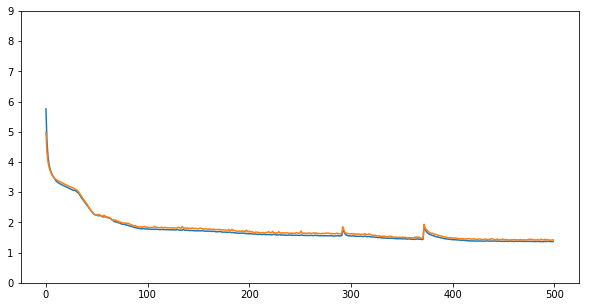

In [5]:
plt.figure(figsize=(10, 5))
plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

## Sampling Functions

The MDN model outputs parameters of a mixture model---a list of means (mu), variances (sigma), and weights (pi).

Below we have some functiosn to split up these parameters and sample from the normal distributions that they form.

In [6]:
# Sample from Categorical distribution
def sample_mixture(mus, sigs, pis):
    """Sample from a mixture of 1D normal distributions parameterised by mus, sigma, and pi."""
    m = np.random.choice(range(len(pis)), p=pis)
    return(np.random.normal(mus[m],sigs[m],1))

def split_mixture_params(params, mixtures, dim):
    """Splits up an array of mixture parameters into mus, sigmas, and pis 
    depending on the number of mixtures and output dimension."""
    mus = params[:mixtures*dim]
    sigs = params[mixtures*dim:2*mixtures*dim]
    pis = params[2*mixtures*dim:]
    return mus,sigs,pis

def adjust_temp(pi_pdf, temp):
    """ Adjusts temperature of a PDF describing a categorical model """
    pi_pdf = np.log(pi_pdf) / temp
    pi_pdf -= pi_pdf.max()
    pi_pdf = np.exp(pi_pdf)
    pi_pdf /= pi_pdf.sum()
    return pi_pdf

def get_pi_idx(x, pdf, temp=1.0, greedy=False):
    """Samples from a categorical model PDF, optionally greedily."""
    if greedy:
        return np.argmax(pdf)
    pdf = adjust_temp(np.copy(pdf), temp)
    accumulate = 0
    for i in range(0, pdf.size):
        accumulate += pdf[i]
        if accumulate >= x:
            return i
    tf.logging.info('Error sampling mixture model.')
    return -1

def sample_from_categorical(dist, temp):
    """Sample from a categorical model with temperature adjustment."""
    r = np.random.rand(1)
    return get_pi_idx(r,dist,temp)

def softmax(w, t=1.0):
    """Softmax function for a list or numpy array of logits."""
    e = np.exp(np.array(w) / t)
    dist = e / np.sum(e)
    return dist

def sample_from_output_1D(params, mixtures, dim, temp=1.0):
    """Sample from a 1D MDN output with temperature adjustment."""
    mus = params[:mixtures*dim]
    sigs = params[mixtures*dim:2*mixtures*dim]
    pis = params[-mixtures:]
    m = sample_from_categorical(pis, temp=temp)
    return(np.random.normal(mus[m],sigs[m],1))

def sample_from_output(params, mixtures, dim, temp=1.0):
    """Sample from an MDN output with temperature adjustment."""
    mus = params[:mixtures*dim]
    sigs = params[mixtures*dim:2*mixtures*dim]
    pis = softmax(params[-mixtures:], t=temp)
    m = sample_from_categorical(pis, temp=temp)
    mus_vector = mus[m*dim:(m+1)*dim]
    sig_vector = sigs[m*dim:(m+1)*dim]
    cov_matrix = np.identity(dim) * sig_vector
    sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
    return sample

## Try out the MDN Model

Now we try out the model by making predictions at 3000 evenly spaced points on the x-axis. 

Mixture models output lists of parameters, so we're going to sample from these parameters for each point on the x-axis, and also try plotting the parameters themselves so we can have some insight into what the model is learning!

In [7]:
## Sample on some test data:
x_test = np.float32(np.arange(-15,15,0.01))
NTEST = x_test.size
print("Testing:", NTEST, "samples.")
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector

# Make predictions from the model
y_test = model.predict(x_test)
# y_test contains parameters for distributions, not actual points on the graph.
# To find points on the graph, we need to sample from each distribution.

# Sample from the predicted distributions
y_samples = np.apply_along_axis(sample_from_output, 1, y_test, N_MIXES,1,temp=1.0)

# Split up the mixture parameters (for future fun)
mus = np.apply_along_axis((lambda a: a[:N_MIXES]),1, y_test)
sigs = np.apply_along_axis((lambda a: a[N_MIXES:2*N_MIXES]),1, y_test)
pis = np.apply_along_axis((lambda a: softmax(a[2*N_MIXES:])),1, y_test)

Testing: 3000 samples.


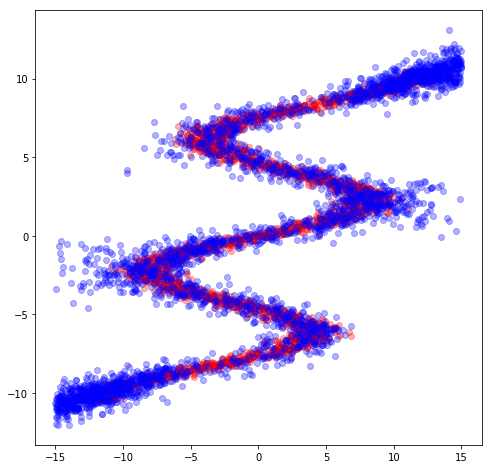

In [8]:
# Plot the samples
plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test, y_samples[:,:,0], 'bo',alpha=0.3)
plt.show()
# These look pretty good!

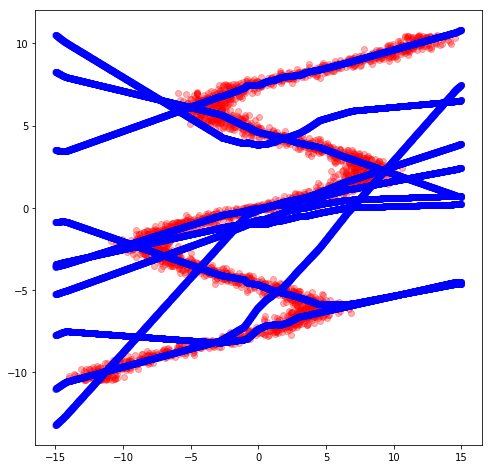

In [9]:
# Plot the means - this gives us some insight into how the model learns to produce the mixtures.
plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test, mus,'bo',alpha=0.3)
plt.show()
# Cool!

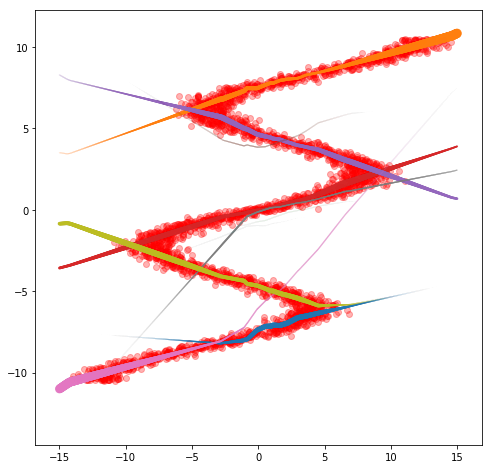

In [10]:
# Let's plot the variances and weightings of the means as well.
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
# ax1.scatter(data[0], data[1], marker='o', c='b', s=data[2], label='the data')
ax1.scatter(x_data,y_data,marker='o', c='r', alpha=0.3)
for i in range(N_MIXES):
    ax1.scatter(x_test, mus[:,i], marker='o', s=200*sigs[:,i]*pis[:,i],alpha=0.3)
plt.show()